In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib_inline import backend_inline
from matplotlib import pyplot as plt
from torch.functional import F
import numpy as np
import pandas as pd
import numba
from numba import jit


In [2]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


In [3]:
def use_svg_display(): 
    backend_inline.set_matplotlib_formats('svg')

In [4]:
from IPython import display

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [5]:

# LSTM模型类
class StockPredictorLSTM(nn.Module):
    def __init__(self, input_size, num_hiddens, output_size, device):
        super(StockPredictorLSTM, self).__init__()
        self.num_hiddens = num_hiddens
        self.lstm = nn.LSTM(input_size, num_hiddens, batch_first=True)
        self.fc = nn.Linear(num_hiddens, output_size)
        self.device = device

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.num_hiddens).to(self.device)
        c0 = torch.zeros(1, X.size(0), self.num_hiddens).to(self.device)
        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 训练一个epoch的函数
def train_epoch(net, train_iter, loss, optimizer, device):
    net.train()
    total_loss = 0
    for X, Y in train_iter:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        output = net(X)
        l = loss(output, Y)
        l.backward()
        optimizer.step()
        total_loss += l.item()
    return total_loss / len(train_iter)

def train(net, train_iter, lr, num_epochs, device):
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs], ylim=[0, 10])

    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, optimizer, device)
        print(f'Epoch {epoch + 1}, Loss: {train_loss:.4f}')
        animator.add(epoch + 1, [train_loss])


In [6]:
import pandas as pd
data = pd.read_csv('data/train_cleaned.csv')
data.drop(['Unnamed: 0'], axis=1, inplace=True)


In [7]:
# data_mini = data.iloc[:42900, :]

In [9]:
data = data[data['stock_id']<=10]

In [9]:
data['seconds_in_bucket'].unique()

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
       390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510,
       520, 530, 540], dtype=int64)

In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm

num_timesteps = 55  # 每个样本的时间步长
features = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 
            'reference_price', 'matched_size', 'far_price', 'near_price', 
            'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']



samples_list = []

def create_samples(group, num_timesteps):
    return np.array([group[i:i + num_timesteps].values for i in range(len(group) - num_timesteps + 1)])

for _, group in tqdm(data.groupby('stock_id')):
    group = group[features]  # 选择特定特征
    samples = create_samples(group, num_timesteps)
    samples_list.append(samples)


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:35<00:00,  1.76s/it]


In [17]:
len(samples_list)

196

In [11]:
samples_array = np.vstack(samples_list)

In [21]:
# #  save samples_array
# np.save('data/samples_array.npy', samples_array)

In [12]:
samples_list[0].shape

(26401, 55, 12)

In [13]:
# 提取标签
labels = data['target']

# 创建标签样本的列表
labels_list = []

# 对于每个stock_id
for _, group in tqdm(data.groupby('stock_id')):
    # 我们需要获取与特征对应的标签
    # 对于每个样本，我们取时间窗口最后一个时间步的标签
    label_samples = create_samples(group[['target']], num_timesteps)
    labels_list.append(label_samples)

# 现在，labels_list 包含了每个样本的标签
# 将labels_list中的所有样本合并为一个数组
all_labels = np.vstack(labels_list)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


In [14]:
all_labels.shape, samples_array.shape

((528020, 55, 1), (528020, 55, 12))

In [15]:

# 0.8作为训练集，0.2作为测试集

X_train = samples_array[:int(data.shape[0] * 0.8), :, :]
X_valid = samples_array[int(data.shape[0] * 0.8):, :, :]
Y_train = all_labels[:int(data.shape[0] * 0.8)]
Y_valid = all_labels[int(data.shape[0] * 0.8):]

# array data to tensor
X_train = torch.from_numpy(X_train).float()
X_valid = torch.from_numpy(X_valid).float()
Y_train = torch.from_numpy(Y_train).float()
Y_valid = torch.from_numpy(Y_valid).float()

In [16]:
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

(torch.Size([423280, 55, 12]),
 torch.Size([104740, 55, 12]),
 torch.Size([423280, 55, 1]),
 torch.Size([104740, 55, 1]))

Epoch 3, Loss: 81.1911


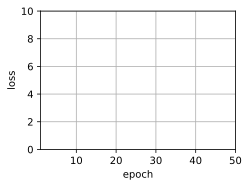

In [18]:

train_features, train_labels = X_train, Y_train

# 创建 TensorDataset
train_dataset = TensorDataset(train_features, train_labels)


batch_size = 55
train_dataset = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 模型参数
input_size = train_features.shape[2] # 特征数量
output_size = 1  # 预测未来60秒的价格变动
num_hiddens = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 实例化模型并开始训练
model = StockPredictorLSTM(input_size, num_hiddens, output_size, device).to(device)
train(model, train_loader, lr=0.001, num_epochs=50, device=device)

In [37]:
class Attention(nn.Module):
    def __init__(self, input_dim):
        super(Attention, self).__init__()
        self.input_dim = input_dim
        self.linear = nn.Linear(input_dim, 1, bias=False)


    def forward(self, x):
        # x 形状: [batch_size, seq_length, input_dim]
        attention_scores = self.linear(x).squeeze(-1)  # 形状: [batch_size, seq_length]
        attention_weights = F.softmax(attention_scores, dim=-1).unsqueeze(-1)  # 形状: [batch_size, seq_length, 1]
        return attention_weights
class AT_LSTM(nn.Module):
    def __init__(self, input_size, num_hiddens, output_size, device):
        super(AT_LSTM, self).__init__()
        self.num_hiddens = num_hiddens
        self.lstm = nn.LSTM(input_size, num_hiddens, batch_first=True)
        self.attention = Attention(num_hiddens)
        self.fc = nn.Linear(num_hiddens, output_size)
        self.device = device

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.num_hiddens).to(self.device)
        c0 = torch.zeros(1, X.size(0), self.num_hiddens).to(self.device)
        lstm_out, _ = self.lstm(X, (h0, c0))  # lstm_out 形状: [batch_size, seq_length, num_hiddens]
        attention_weights = self.attention(lstm_out)
        weighted_lstm_out = lstm_out * attention_weights  # 应用注意力权重
        weighted_lstm_out = weighted_lstm_out.sum(dim=1)  # 聚合加权特征
        output = self.fc(weighted_lstm_out)
        return output, attention_weights


In [38]:
def at_train_epoch(net, train_iter, loss, optimizer, device):
    net.train()
    total_loss = 0
    for X, Y in train_iter:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        output, _ = net(X)  # 修改这一行以获取输出张量
        l = loss(output, Y)
        l.backward()
        optimizer.step()
        total_loss += l.item()
    return total_loss / len(train_iter)

def at_train(net, train_iter, lr, num_epochs, device):
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs], ylim=[0, 10])

    for epoch in range(num_epochs):
        train_loss = at_train_epoch(net, train_iter, loss, optimizer, device)
        print(f'Epoch {epoch + 1}, Loss: {train_loss:.4f}')
        animator.add(epoch + 1, [train_loss])


In [ ]:
train_features, train_labels = X_train, Y_train

# 创建 TensorDataset
train_dataset = TensorDataset(train_features, train_labels)


batch_size = 55
train_dataset = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 模型参数
input_size = train_features.shape[2] # 特征数量
output_size = 1  # 预测未来60秒的价格变动
num_hiddens = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 实例化模型并开始训练
model = AT_LSTM(input_size, num_hiddens, output_size, device).to(device)
at_train(model, train_loader, lr=0.001, num_epochs=50, device=device)

In [47]:
train_features.shape

torch.Size([1000, 10, 5])

In [43]:
inputs, _ = next(iter(train_loader))  # 获取一批数据
outputs, attention_weights = model(inputs.to(device))

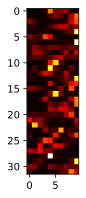

In [46]:
# 绘制注意力权重矩阵
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.imshow(attention_weights.detach().cpu().numpy(), cmap='hot')
plt.show()